<a href="https://www.kaggle.com/code/ocanaydin/football-pl-pred-results?scriptVersionId=113972516" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/football-coaching/football.csv


**READ DATA**

In [2]:
df = pd.read_csv("../input/football-coaching/football.csv")
df.head(5)

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,BbAv<2.5,BbAH,BbAHh,BbMxAHH,BbAvAHH,BbMxAHA,BbAvAHA,PSCH,PSCD,PSCA
0,E0,13/08/16,Burnley,Swansea,0,1,A,0,0,D,...,1.61,32,-0.25,2.13,2.06,1.86,1.81,2.79,3.16,2.89
1,E0,13/08/16,Crystal Palace,West Brom,0,1,A,0,0,D,...,1.52,33,-0.50,2.07,2.00,1.90,1.85,2.25,3.15,3.86
2,E0,13/08/16,Everton,Tottenham,1,1,D,1,0,H,...,1.77,32,0.25,1.91,1.85,2.09,2.00,3.64,3.54,2.16
3,E0,13/08/16,Hull,Leicester,2,1,H,1,0,H,...,1.67,31,0.25,2.35,2.26,2.03,1.67,4.68,3.50,1.92
4,E0,13/08/16,Man City,Sunderland,2,1,H,1,0,H,...,2.48,34,-1.50,1.81,1.73,2.20,2.14,1.25,6.50,14.50


**FIND MOST SCORER HOME AND AWAY TEAMS**

In [4]:
"""Home scorer."""
df_home_scorer = df.groupby(["HomeTeam"]).agg({"FTHG" : "sum","FTAG" : "sum"}).sort_values(["FTHG"],ascending = False).reset_index()
df_home_scorer["GD"] = df_home_scorer["FTHG"] - df_home_scorer["FTAG"]
print(df_home_scorer.head())
"""Away scorer."""
df_away_scorer = df.groupby(["AwayTeam"]).agg({"FTHG" : "sum" , "FTAG" : "sum"}).sort_values(["FTAG"],ascending = False).reset_index()
df_away_scorer["GD"] = df_away_scorer["FTAG"] - df_away_scorer["FTHG"]
print(df_away_scorer.head())

    HomeTeam  FTHG  FTAG  GD
0    Chelsea    55    17  38
1  Tottenham    47     9  38
2  Liverpool    45    18  27
3    Everton    42    16  26
4    Arsenal    39    16  23
    AwayTeam  FTHG  FTAG  GD
0   Man City    22    43  21
1  Tottenham    17    39  22
2    Arsenal    28    38  10
3  Liverpool    24    33   9
4    Chelsea    16    30  14


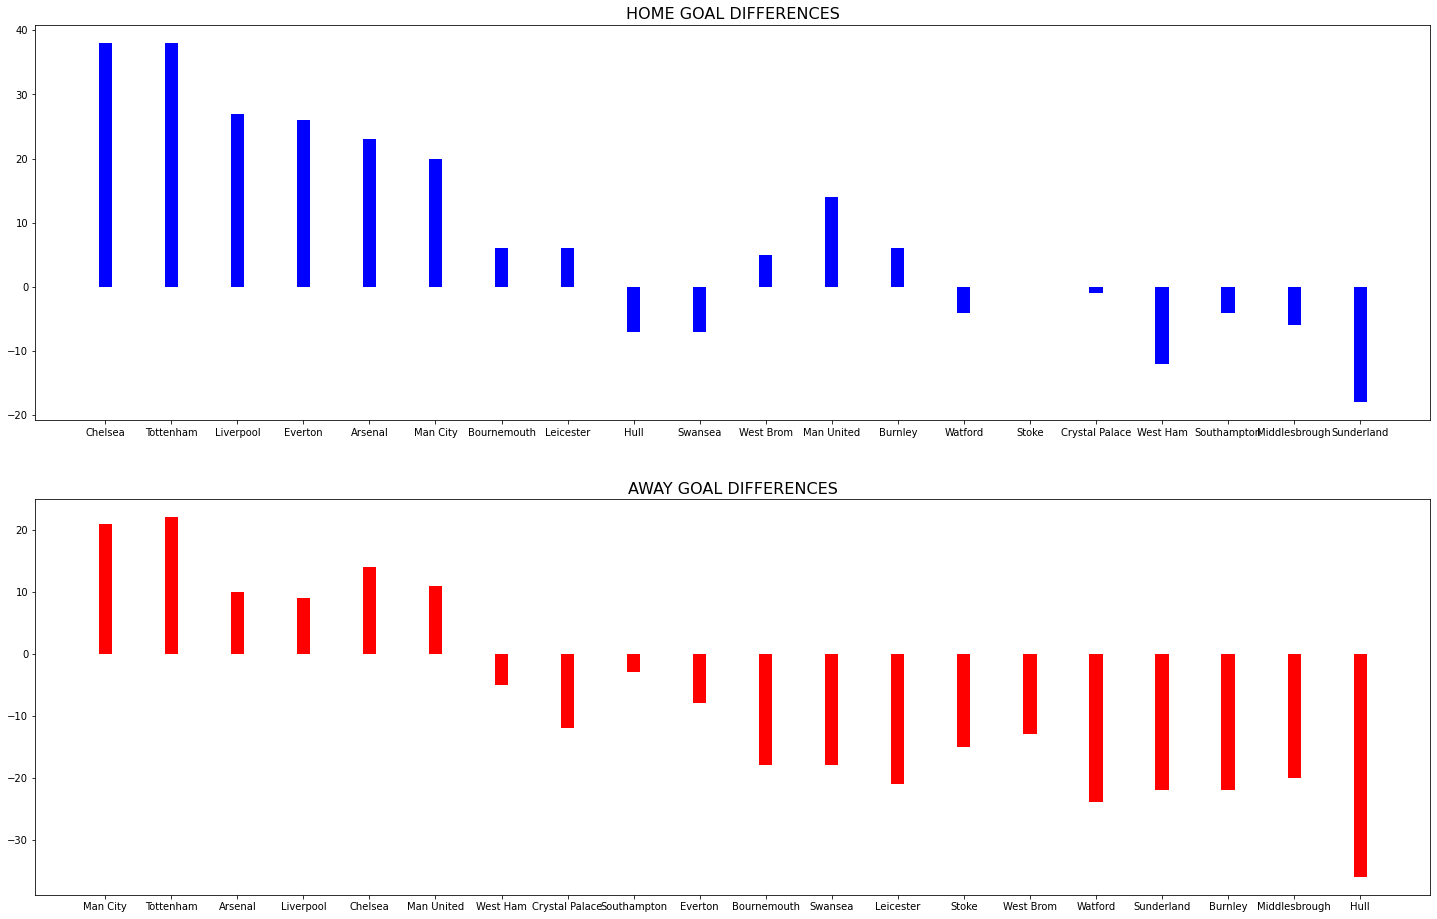

In [5]:
"""Plot home goal differences."""
import matplotlib.pyplot as plt
import seaborn as sns
fig,ax = plt.subplots(2,1,figsize = (25,16))
ax[0].bar(df_home_scorer["HomeTeam"],df_home_scorer["GD"],color = "b",width = 0.2)
ax[0].set_title("HOME GOAL DIFFERENCES",fontsize = 16)
ax[1].bar(df_away_scorer["AwayTeam"],df_away_scorer["GD"],color = "r",width = 0.2)
ax[1].set_title("AWAY GOAL DIFFERENCES",fontsize = 16)
plt.show()


**CONVERT "A","D","W" to points by home or away.After that concatenate them.**

In [7]:
"""This function converts {A,D,W} to points team by team."""
def convert_to_points(pitch,points_dict):
    team_points = []
    schedule = df.groupby([pitch]).agg({"FTR" : "sum"})
    #We have 20 team.
    for i in range(20):
        point = 0
        for j in range(19):
            point += points_dict[schedule.iloc[i][0][j]]
        team_points.append(point)
    return team_points

In [8]:
"""Calculate home and away points of teams with help of above function."""
home_points = convert_to_points("HomeTeam",{"A" : 0,"D" : 1,"H" : 3})
away_points = convert_to_points("AwayTeam",{"A" : 3,"D" : 1,"H" : 0})

In [9]:
"""Get both home and away schedules."""
home_schedule = df.groupby(["HomeTeam"]).agg({"FTR" : "sum"})
away_schedule = df.groupby(["AwayTeam"]).agg({"FTR" :"sum"})

In [10]:
home_schedule.head(3)

,FTR
HomeTeam,
Arsenal,AHHHDDHHHHHAHDHHHHH
Bournemouth,AHHHDAHHADDAAHHAHDH
Burnley,AHDHAHHAHHHHHDAHADA


In [11]:
"""Add home and away points to schudules and drop String type expression like A,D,W."""
home_schedule["HomePoints"] = home_points
home_schedule.drop(columns = ["FTR"],inplace = True)

away_schedule["AwayPoints"] = away_points
away_schedule.drop(columns = ["FTR"],inplace = True)

In [12]:
"""Here we concatenate both schedules and obtain PL 16/17 points table."""
PL_table = pd.concat([home_schedule,away_schedule],axis = 1)
PL_table["Points"] = PL_table["HomePoints"] + PL_table["AwayPoints"]
PL_table = PL_table.sort_values(["Points"],ascending = False).reset_index()
PL_table.rename(columns = {"index" : "Team"},inplace = True)
PL_table

,Team,HomePoints,AwayPoints,Points
0,Chelsea,51,42,93
1,Tottenham,53,33,86
2,Man City,40,38,78
3,Liverpool,41,35,76
4,Arsenal,45,30,75
5,Man United,34,35,69
6,Everton,43,18,61
7,Bournemouth,31,15,46
8,Southampton,24,22,46
9,West Brom,29,16,45


In [13]:
"""Sort table with home and away points."""
home_table = PL_table.sort_values(["HomePoints"],ascending = False).reset_index()
home_table.drop(columns = ["index"],inplace = True)

away_table = PL_table.sort_values(["AwayPoints"],ascending = False).reset_index()
away_table.drop(columns = ["index"],inplace = True)

**PLOT POINTS TABLES**

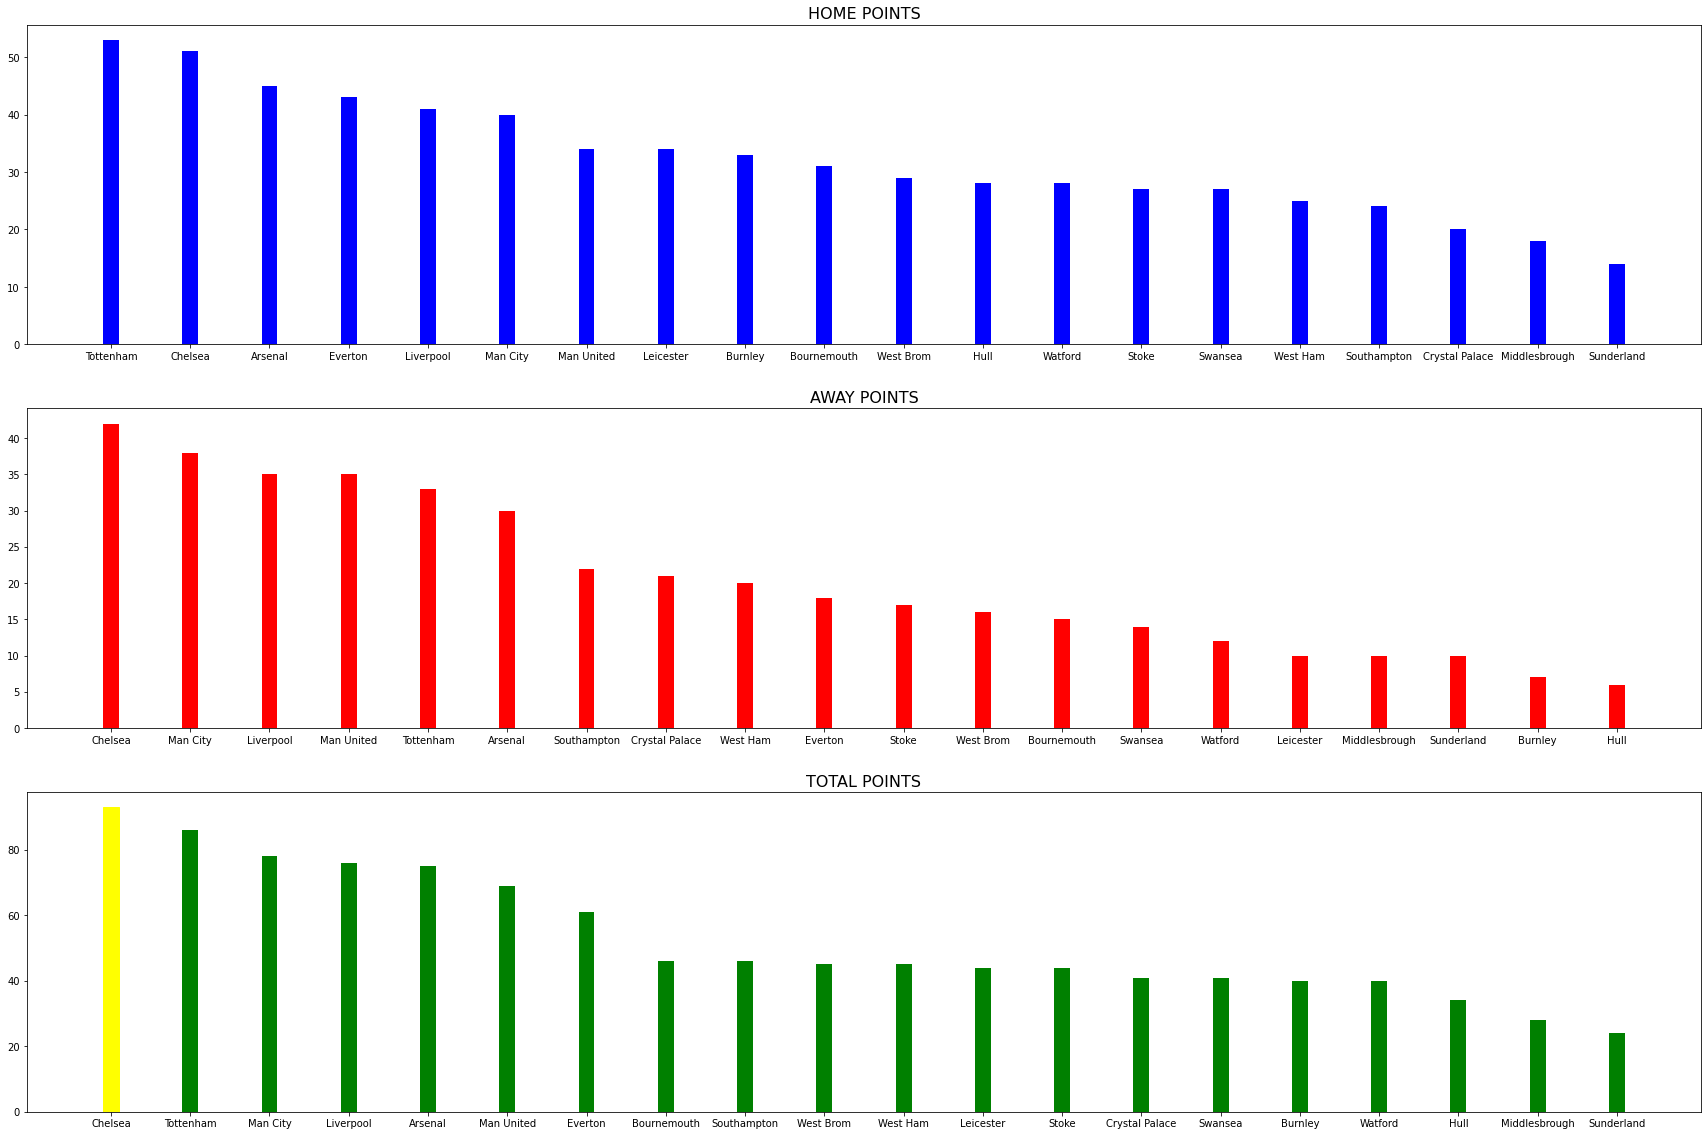

In [14]:
fig,ax = plt.subplots(3,1,figsize = (30,20))
ax[0].bar(home_table["Team"],home_table["HomePoints"],color = "b",width = 0.2)
ax[0].set_title("HOME POINTS",fontsize = 16)

ax[1].bar(away_table["Team"],away_table["AwayPoints"],color = "r",width = 0.2)
ax[1].set_title("AWAY POINTS",fontsize = 16)

result = ax[2].bar(PL_table["Team"],PL_table["Points"],color = "g",width = 0.2)
ax[2].set_title("TOTAL POINTS",fontsize = 16)
result[0].set_color("yellow")
plt.show()

**Transform categorical columns to numerical.**

In [15]:
"""Find categorical columns."""
cols = df.columns
num_cols = df._get_numeric_data().columns
categorical_cols = list(set(cols) - set(num_cols))
print(categorical_cols)

['HomeTeam', 'Div', 'Date', 'HTR', 'AwayTeam', 'Referee', 'FTR']


In [16]:
"""Create copy of dataframe to make operations on it."""
df_copy = df.copy()

In [17]:
print(df_copy[categorical_cols])
from sklearn.preprocessing import LabelEncoder
LE = LabelEncoder()
df_home_away_teams = df[["HomeTeam","AwayTeam"]]
"""We can convert home_team,away_team,referee columns to numerical."""
df_copy["HomeTeam"] = LE.fit_transform(df_copy["HomeTeam"])
df_copy["AwayTeam"] = LE.fit_transform(df_copy["AwayTeam"])
df_copy["Referee"] = LE.fit_transform(df_copy["Referee"])

           HomeTeam Div      Date HTR        AwayTeam     Referee FTR
0           Burnley  E0  13/08/16   D         Swansea      J Moss   A
1    Crystal Palace  E0  13/08/16   D       West Brom    C Pawson   A
2           Everton  E0  13/08/16   H       Tottenham  M Atkinson   D
3              Hull  E0  13/08/16   H       Leicester      M Dean   H
4          Man City  E0  13/08/16   H      Sunderland    R Madley   H
..              ...  ..       ...  ..             ...         ...  ..
375       Liverpool  E0  21/05/17   H   Middlesbrough  M Atkinson   H
376      Man United  E0  21/05/17   H  Crystal Palace    A Taylor   H
377     Southampton  E0  21/05/17   D           Stoke   L Probert   A
378         Swansea  E0  21/05/17   A       West Brom      M Dean   H
379         Watford  E0  21/05/17   A        Man City      J Moss   A

[380 rows x 7 columns]


In [18]:
"""We can keep div,date in another df with categorical team names.After that,we should delete Div,Date,HTR columns."""
df_match_info = pd.concat([df_copy[["Div","Date"]],df_home_away_teams],axis = 1)
df_copy.drop(columns = ["Div","Date","HTR"],inplace = True)
df_copy.head(5)

,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,Referee,HS,AS,...,BbAv<2.5,BbAH,BbAHh,BbMxAHH,BbAvAHH,BbMxAHA,BbAvAHA,PSCH,PSCD,PSCA
0,2,15,0,1,A,0,0,5,10,17,...,1.61,32,-0.25,2.13,2.06,1.86,1.81,2.79,3.16,2.89
1,4,18,0,1,A,0,0,3,14,13,...,1.52,33,-0.50,2.07,2.00,1.90,1.85,2.25,3.15,3.86
2,5,16,1,1,D,1,0,9,12,13,...,1.77,32,0.25,1.91,1.85,2.09,2.00,3.64,3.54,2.16
3,6,7,2,1,H,1,0,11,14,18,...,1.67,31,0.25,2.35,2.26,2.03,1.67,4.68,3.50,1.92
4,9,14,2,1,H,1,0,17,16,7,...,2.48,34,-1.50,1.81,1.73,2.20,2.14,1.25,6.50,14.50


In [19]:
"""Optionally,we can delete HTHG,HTAG columns because we want to know Full time results.You can also predict them if you want."""
df_copy.drop(columns = ["HTHG","HTAG"],inplace = True)
df_copy.head(5)

,HomeTeam,AwayTeam,FTHG,FTAG,FTR,Referee,HS,AS,HST,AST,...,BbAv<2.5,BbAH,BbAHh,BbMxAHH,BbAvAHH,BbMxAHA,BbAvAHA,PSCH,PSCD,PSCA
0,2,15,0,1,A,5,10,17,3,9,...,1.61,32,-0.25,2.13,2.06,1.86,1.81,2.79,3.16,2.89
1,4,18,0,1,A,3,14,13,4,3,...,1.52,33,-0.50,2.07,2.00,1.90,1.85,2.25,3.15,3.86
2,5,16,1,1,D,9,12,13,6,4,...,1.77,32,0.25,1.91,1.85,2.09,2.00,3.64,3.54,2.16
3,6,7,2,1,H,11,14,18,5,5,...,1.67,31,0.25,2.35,2.26,2.03,1.67,4.68,3.50,1.92
4,9,14,2,1,H,17,16,7,4,3,...,2.48,34,-1.50,1.81,1.73,2.20,2.14,1.25,6.50,14.50


In [20]:
"""This mapping converts full time result to 0-1-2 system(like in bet.)"""
df_copy["FTR"] = df_copy["FTR"].map({"H" : 1,"D" : 0,"A" : 2})

In [21]:
df_copy

,HomeTeam,AwayTeam,FTHG,FTAG,FTR,Referee,HS,AS,HST,AST,...,BbAv<2.5,BbAH,BbAHh,BbMxAHH,BbAvAHH,BbMxAHA,BbAvAHA,PSCH,PSCD,PSCA
0,2,15,0,1,2,5,10,17,3,9,...,1.61,32,-0.25,2.13,2.06,1.86,1.81,2.79,3.16,2.89
1,4,18,0,1,2,3,14,13,4,3,...,1.52,33,-0.50,2.07,2.00,1.90,1.85,2.25,3.15,3.86
2,5,16,1,1,0,9,12,13,6,4,...,1.77,32,0.25,1.91,1.85,2.09,2.00,3.64,3.54,2.16
3,6,7,2,1,1,11,14,18,5,5,...,1.67,31,0.25,2.35,2.26,2.03,1.67,4.68,3.50,1.92
4,9,14,2,1,1,17,16,7,4,3,...,2.48,34,-1.50,1.81,1.73,2.20,2.14,1.25,6.50,14.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,8,11,3,0,1,9,25,9,10,3,...,2.73,18,-2.50,2.02,1.97,1.95,1.90,1.15,10.50,19.09
376,10,4,2,0,1,1,9,6,2,1,...,1.81,19,-0.25,2.19,2.11,1.85,1.79,2.35,3.38,3.35
377,12,13,0,1,2,8,14,14,6,3,...,2.01,18,-0.75,2.03,1.98,1.93,1.88,1.64,4.37,5.53
378,15,18,2,1,1,11,12,16,2,5,...,1.98,19,-0.50,2.11,2.06,1.86,1.82,2.29,3.45,3.40


**Seperate data as X and Y.**

In [22]:
"""X includes our features,Y includes full time results."""
y_cols = ["FTHG","FTAG","FTR"]
Y = df_copy[y_cols]
X = df_copy.drop(columns = y_cols)
print(X.head(5))
print(Y.head(5))

   HomeTeam  AwayTeam  Referee  HS  AS  HST  AST  HF  AF  HC  ...  BbAv<2.5  \
0         2        15        5  10  17    3    9  10  14   7  ...      1.61   
1         4        18        3  14  13    4    3  12  15   3  ...      1.52   
2         5        16        9  12  13    6    4  10  14   5  ...      1.77   
3         6         7       11  14  18    5    5   8  17   5  ...      1.67   
4         9        14       17  16   7    4    3  11  14   9  ...      2.48   

   BbAH  BbAHh  BbMxAHH  BbAvAHH  BbMxAHA  BbAvAHA  PSCH  PSCD   PSCA  
0    32  -0.25     2.13     2.06     1.86     1.81  2.79  3.16   2.89  
1    33  -0.50     2.07     2.00     1.90     1.85  2.25  3.15   3.86  
2    32   0.25     1.91     1.85     2.09     2.00  3.64  3.54   2.16  
3    31   0.25     2.35     2.26     2.03     1.67  4.68  3.50   1.92  
4    34  -1.50     1.81     1.73     2.20     2.14  1.25  6.50  14.50  

[5 rows x 57 columns]
   FTHG  FTAG  FTR
0     0     1    2
1     0     1    2
2     1     1

**STANDARDIZATION OF FEATURES**

In [23]:
from sklearn.preprocessing import StandardScaler
SS = StandardScaler()
"""We can standardizate all features except Team names(cause they are unique,we dont need to standardizate them.)"""
numerical_teams = X[["HomeTeam","AwayTeam"]]
X.drop(columns = ["HomeTeam","AwayTeam"],inplace = True)

In [24]:
"""Standardization of x data."""
X = pd.DataFrame(SS.fit_transform(X),columns = X.columns)

In [25]:
"""Now we can concatenate both teams and X features."""
X = pd.concat([numerical_teams,X],axis = 1)
X.head(5)

,HomeTeam,AwayTeam,Referee,HS,AS,HST,AST,HF,AF,HC,...,BbAv<2.5,BbAH,BbAHh,BbMxAHH,BbAvAHH,BbMxAHA,BbAvAHA,PSCH,PSCD,PSCA
0,2,15,-0.717470,-0.683638,1.100329,-0.644477,2.161369,-0.306891,0.659433,0.428794,...,-1.161369,1.131624,0.084285,0.602617,0.632596,-0.731174,-0.714604,-0.112220,-0.814821,-0.527238
1,4,18,-1.085901,-0.002241,0.302381,-0.289033,-0.359307,0.270429,0.940989,-0.869547,...,-1.421956,1.339763,-0.184861,0.288496,0.286135,-0.503943,-0.471335,-0.356674,-0.821822,-0.296516
2,5,16,0.019391,-0.342940,0.302381,0.421857,0.060806,-0.306891,0.659433,-0.220376,...,-0.698101,1.131624,0.622578,-0.549161,-0.580019,0.575401,0.440926,0.272569,-0.548814,-0.700875
3,6,7,0.387822,-0.002241,1.299817,0.066412,0.480918,-0.884211,1.504100,-0.220376,...,-0.987643,0.923484,0.622578,1.754395,1.787468,0.234556,-1.566048,0.743369,-0.576815,-0.757961
4,9,14,1.493113,0.338457,-0.894543,-0.289033,-0.359307,-0.018231,0.659433,1.077965,...,1.357648,1.547903,-1.261447,-1.072696,-1.272942,1.200285,1.292370,-0.809367,1.523240,2.234298


**SPLIT DATAS AS TRAIN AND TEST**

In [26]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size = 0.3,random_state = 42)

In [27]:
X_train.head(5)

,HomeTeam,AwayTeam,Referee,HS,AS,HST,AST,HF,AF,HC,...,BbAv<2.5,BbAH,BbAHh,BbMxAHH,BbAvAHH,BbMxAHA,BbAvAHA,PSCH,PSCD,PSCA
334,4,2,1.493113,0.168108,-0.495568,0.066412,-0.359307,-0.018231,0.096322,2.700891,...,-0.784964,-0.949775,-0.184861,-0.915636,-0.926481,0.916247,1.049100,-0.533224,-0.618816,0.017458
341,11,9,-0.533255,-0.002241,2.097765,0.421857,0.060806,-0.595551,-0.748345,-0.544962,...,1.560327,-1.157915,1.968310,0.602617,0.690340,-0.844789,-0.836239,3.984649,1.397237,-0.910190
375,8,11,0.019391,1.871600,-0.495568,1.843636,-0.359307,0.559088,-1.029901,-0.869547,...,2.081503,-1.782334,-2.338033,0.026728,0.112904,-0.219905,-0.167248,-0.854636,4.323313,3.326068
289,12,1,-0.717470,-0.002241,0.102893,-0.289033,-0.359307,0.847748,-1.029901,0.104209,...,0.257388,-0.533495,-0.723154,0.759677,0.863570,-0.844789,-0.897057,-0.619236,-0.135804,0.105465
223,8,3,0.203606,-1.194686,-0.695055,-0.644477,-0.779420,0.559088,-1.029901,-0.869547,...,-0.611239,0.299064,0.353432,-0.706222,-0.695506,0.575401,0.684196,-0.207286,-0.786821,-0.472531


**PREDICTION**

In [224]:
"""Here,i used xgboost regressor for prediction.You can use your prefered algorithm if you want.Also you can change params."""
import xgboost as xgb
xgb_regressor = xgb.XGBRegressor(booster = "gbtree",max_depth = 8,gamma = 0.3,alpha = 0.4,reg_lambda = 1.1,
                                learning_rate = 0.05,min_child_weight = 2)
xgb_regressor.fit(X_train.values,Y_train.values)

XGBRegressor(alpha=0.4, base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0.3, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=8, max_leaves=0, min_child_weight=2,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0.400000006, ...)

In [225]:
preds = xgb_regressor.predict(X_test.values)

In [226]:
"""Convert preds to dataframe.After that,we can round preds(cause goals must be int(like 0-1-2-3-4))"""
preds = pd.DataFrame(preds,columns = ["pred_FTHG","pred_FTAG","pred_FTR"],index = X_test.index)
preds = round(preds)

In [227]:
"""Add x_test team numbers to dataframe."""
preds_with_teams = pd.concat([X_test[["HomeTeam","AwayTeam"]],preds],axis = 1)
result = pd.concat([preds_with_teams,Y_test],axis = 1)

In [228]:
result.head(5)

,HomeTeam,AwayTeam,pred_FTHG,pred_FTAG,pred_FTR,FTHG,FTAG,FTR
266,16,5,2.0,1.0,1.0,3,2,1
261,13,11,1.0,0.0,1.0,2,0,1
265,14,9,0.0,3.0,2.0,0,2,2
39,14,5,0.0,3.0,1.0,0,3,2
33,8,7,4.0,1.0,1.0,4,1,1


In [229]:
"""Finally,we can add team names to dataframe."""
result.drop(columns = ["HomeTeam","AwayTeam"],axis = 1)
final_result = pd.concat([df_match_info.iloc[result.index,:],result],axis = 1)

In [230]:
"""Here you can change the interval of datas."""
final_result.iloc[20:50,:]

,Div,Date,HomeTeam,AwayTeam,HomeTeam,AwayTeam,pred_FTHG,pred_FTAG,pred_FTR,FTHG,FTAG,FTR
15,E0,20/08/16,Tottenham,Crystal Palace,16,4,2.0,1.0,1.0,1,0,1
246,E0,11/02/17,West Ham,West Brom,19,18,2.0,1.0,1.0,2,2,0
374,E0,21/05/17,Leicester,Bournemouth,7,1,1.0,1.0,1.0,1,1,0
0,E0,13/08/16,Burnley,Swansea,2,15,1.0,3.0,1.0,0,1,2
78,E0,16/10/16,Southampton,Burnley,12,2,4.0,0.0,1.0,3,1,1
258,E0,04/03/17,Leicester,Hull,7,6,2.0,1.0,1.0,3,1,1
25,E0,27/08/16,Southampton,Sunderland,12,14,1.0,1.0,1.0,1,1,0
46,E0,18/09/16,Crystal Palace,Stoke,4,13,2.0,1.0,1.0,4,1,1
9,E0,15/08/16,Chelsea,West Ham,3,19,1.0,1.0,1.0,2,1,1
76,E0,15/10/16,West Brom,Tottenham,18,16,2.0,3.0,2.0,1,1,0


In [231]:
"""Accuracy metrix to check useability of model."""
from sklearn.metrics import accuracy_score
home_goal_acc = accuracy_score(Y_test["FTHG"],final_result["pred_FTHG"])
away_goal_acc = accuracy_score(Y_test["FTAG"],final_result["pred_FTAG"])
full_time_result_acc = accuracy_score(Y_test["FTR"],final_result["pred_FTR"])
print(f"Home goal accuracy : %{100 * home_goal_acc}\nAway goal accuracy : %{100 * away_goal_acc}")
print(f"Full time result accuracy : %{100 * full_time_result_acc}")

Home goal accuracy : %39.473684210526315
Away goal accuracy : %41.228070175438596
Full time result accuracy : %62.28070175438597
